<a href="https://colab.research.google.com/github/emilianodesu/RLA2/blob/main/cartpole/cart-pole-ppo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![View on GitHub](https://img.shields.io/badge/GitHub-Repo-blue?logo=github)](https://github.com/emilianodesu/RLA2)

## Cloning repository to execute in Google Colab

In [1]:
import os
def detect_colab() -> bool:
    """
    Detect whether the runtime is Google Colab.

    Returns:
        bool: True if running in Google Colab; False otherwise.
    """
    try:
        import google.colab  # type: ignore
        return True
    except ImportError:
        return False

IN_COLAB = detect_colab()
BASE_PATH = '/content/' if IN_COLAB else './'

print(f"IN_COLAB: {IN_COLAB}")
print(f"BASE_PATH: {BASE_PATH}")

if IN_COLAB:
    # Clone Github repo
    if not os.path.exists(f"{BASE_PATH}/RLA2"):
        !git clone https://github.com/emilianodesu/RLA2.git
    os.chdir(f"{BASE_PATH}/RLA2")
    print(f"Current directory: {os.getcwd()}")

IN_COLAB: True
BASE_PATH: /content/
Cloning into 'RLA2'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 167 (delta 44), reused 110 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (167/167), 7.13 MiB | 8.14 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Filtering content: 100% (32/32), 516.60 MiB | 44.45 MiB/s, done.
Current directory: /content/RLA2


# PPO on classic control

This notebook will explore the implementation of PPO from Stable Baselines3 on a classic-control environment.

### What you will learn?
* Using PPO from Stable Baseline3
* Training on cart pole environment

## Setup
Install necessary dependencies.

In [6]:
!pip install gymnasium
!pip install "stable-baselines3[extra]"
!pip install moviepy
!sudo apt-get update
!apt-get install -y xvfb ffmpeg freeglut3-dev

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

Import libraries

In [8]:
# Import necessary libraries and modules
import os
import gymnasium as gym
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import base64
from IPython import display as ipythondisplay
import torch

print(f"{gym.__version__=}")
print(f"{stable_baselines3.__version__=}")

gym.__version__='1.2.1'
stable_baselines3.__version__='2.7.0'


Configure environment

In [4]:
# Set up a fake display for rendering videos in the cloud environment
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

## Callbacks and directory setup

In [5]:
# Callback for saving the model at regular intervals
class SaveOnIntervalCallback(BaseCallback):
    def __init__(self, save_interval: int, save_path: str, verbose=1):
        super().__init__(verbose)
        self.save_interval = save_interval
        self.save_path = save_path

    def _on_step(self) -> bool:
        if self.num_timesteps % self.save_interval == 0:
            save_file = os.path.join(self.save_path, f'model_{self.num_timesteps}')
            self.model.save(save_file)
            if self.verbose > 0:
                print(f'Saving model to {save_file}.zip')
        return True

In [7]:
# Creating directories for storing logs and models
if IN_COLAB:
    log_dir = "/content/RLA2/cartpole/ppo/logs/"
    models_dir = "/content/RLA2/cartpole/ppo/models/"
    videos_dir = "/content/RLA2/cartpole/ppo/videos/"
else:
    log_dir = "ppo/logs/"
    models_dir = "ppo/models/"
    videos_dir = "ppo/videos"

os.makedirs(log_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(videos_dir, exist_ok=True)

## Cart pole environment

In [14]:
env_id = "CartPole-v1"
def make_env():
    env = gym.make(env_id)
    env = Monitor(env, log_dir)
    return env

env = DummyVecEnv([make_env])

## PPO Model

In [15]:
policy_kwargs = dict(
    net_arch=[dict(pi=[64, 64], vf=[64, 64])],
    activation_fn=torch.nn.Tanh
)

model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,               # Standard, works very well for CartPole
    n_steps=2048,                     # Large batch per update → stable gradients
    batch_size=64,                    # Minibatch size during each update
    n_epochs=10,                      # Number of epochs per batch
    gamma=0.99,                       # Discount factor
    gae_lambda=0.95,                  # GAE smoothing
    clip_range=0.2,                   # Default clipping is usually ideal
    ent_coef=0.0,                     # No entropy bonus needed for CartPole
    vf_coef=0.5,                      # Default value function coefficient
    max_grad_norm=0.5,                # Gradient clipping
    policy_kwargs=policy_kwargs # Use our custom network
)

Using cpu device


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


## Train the model

In [16]:
# Set up the callback for saving models
save_interval = 100_000
save_callback = SaveOnIntervalCallback(save_interval=save_interval, save_path=models_dir)

total_timesteps = 500_000

# Train the DQN agent
model.learn(total_timesteps=total_timesteps, callback=save_callback)

# Save the final trained model
final_model_path = os.path.join(models_dir, f'model_{total_timesteps}')
model.save(final_model_path)

Streaming output truncated to the last 5000 lines.
|    ep_rew_mean          | 115         |
| time/                   |             |
|    fps                  | 742         |
|    iterations           | 8           |
|    time_elapsed         | 22          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.008382795 |
|    clip_fraction        | 0.0745      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.576      |
|    explained_variance   | 0.764       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.8        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0091     |
|    value_loss           | 38.5        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 136         |
|    ep_rew_mean          | 136         |
| time/                  

## Performance evaluation

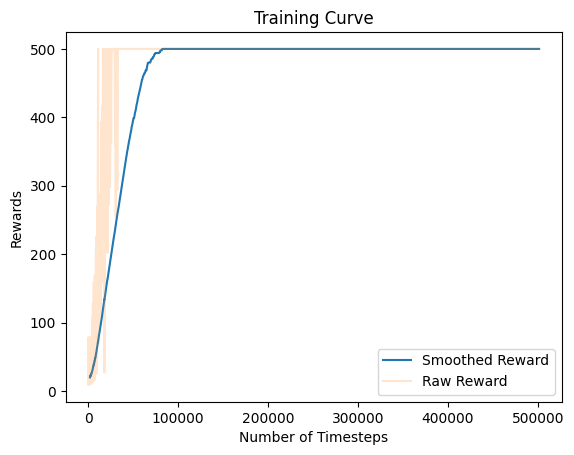

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [18]:
def plot_results(log_folder: str):
    """
    Plots the training curve from the Monitor log file.
    :param log_folder: the save directory of the Monitor logs
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')

    # Smooth the curve
    y_smooth = np.convolve(y, np.ones(100)/100, mode='valid')
    x_smooth = x[len(x) - len(y_smooth):]

    fig = plt.figure("Training Curve")
    plt.plot(x_smooth, y_smooth, label="Smoothed Reward")
    plt.plot(x, y, alpha=0.2, label="Raw Reward")
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title("Training Curve")
    plt.legend()
    plt.show()

# Call the function after training to see the learning curve
plot_results(log_dir)

## Video Recording and Display Functions

In [19]:
# Functions to record and show videos of the agent playing

def show_videos(video_path="", prefix=""):
    html = []
    for mp4 in Path(video_path).glob(f"{prefix}*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            f'''<video alt="{mp4.name}" autoplay loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{video_b64.decode('ascii')}" type="video/mp4" />
             </video>'''
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

# ### MODIFICATION ###: Updated video folder and env_id
def record_video(env_id, model, video_length=500, prefix="", video_folder="ppo/videos"):
    os.makedirs(video_folder, exist_ok=True)
    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )
    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs, deterministic=True) # Use deterministic for evaluation
        obs, _, _, _ = eval_env.step(action)
    eval_env.close()

In [20]:
# Functions for analyzing the trained models

# Function to get the identifiers of saved models
def get_model_identifiers(models_dir):
    files = os.listdir(models_dir)  # Listing files in the models directory
    model_files = [f for f in files if f.startswith('model_')]  # Filtering out model files
    identifiers = [f.split('_')[1] for f in model_files]  # Extracting identifiers from file names
    return identifiers

# Function to find key identifiers (earliest, middle, final)
def find_key_identifiers(identifiers):
    identifiers.sort()  # Sorting identifiers
    earliest = identifiers[0]  # Earliest identifier
    final = identifiers[-1]  # Final identifier
    middle = identifiers[len(identifiers) // 2]  # Middle identifier
    return earliest, middle, final

# Function to view videos of the models at different training stages
def view(models_dir, video_folder="ppo/videos"):
    identifiers = get_model_identifiers(models_dir)  # Getting model identifiers
    print(identifiers)
    earliest, middle, final = find_key_identifiers(identifiers)  # Finding key identifiers

    # Recording and displaying videos at the beginning, middle, and end of training
    for stage, identifier in zip(["beginning", "middle", "end"], [earliest, middle, final]):
        model_path = os.path.join(models_dir, f'model_{identifier}')  # Forming the model path
        model = PPO.load(model_path)  # Loading the model
        record_video("CartPole-v1", model, video_length=5000, prefix=f'ppo-cartpole-{stage}', video_folder=video_folder)  # Recording video
        show_videos(videos_dir, prefix=f'ppo-cartpole-{stage}')  # Showing videos

In [21]:
view(models_dir=models_dir, video_folder=videos_dir)  # Calling the view function

['500000.zip', '200000.zip', '300000.zip', '400000.zip', '100000.zip']


/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Saving video to /content/RLA2/cartpole/ppo/videos/ppo-cartpole-beginning-step-0-to-step-5000.mp4


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


Moviepy - Building video /content/RLA2/cartpole/ppo/videos/ppo-cartpole-beginning-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/RLA2/cartpole/ppo/videos/ppo-cartpole-beginning-step-0-to-step-5000.mp4



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Moviepy - Done !
Moviepy - video ready /content/RLA2/cartpole/ppo/videos/ppo-cartpole-beginning-step-0-to-step-5000.mp4


Saving video to /content/RLA2/cartpole/ppo/videos/ppo-cartpole-middle-step-0-to-step-5000.mp4
Moviepy - Building video /content/RLA2/cartpole/ppo/videos/ppo-cartpole-middle-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/RLA2/cartpole/ppo/videos/ppo-cartpole-middle-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/RLA2/cartpole/ppo/videos/ppo-cartpole-middle-step-0-to-step-5000.mp4


Saving video to /content/RLA2/cartpole/ppo/videos/ppo-cartpole-end-step-0-to-step-5000.mp4
Moviepy - Building video /content/RLA2/cartpole/ppo/videos/ppo-cartpole-end-step-0-to-step-5000.mp4.
Moviepy - Writing video /content/RLA2/cartpole/ppo/videos/ppo-cartpole-end-step-0-to-step-5000.mp4



Moviepy - Done !
Moviepy - video ready /content/RLA2/cartpole/ppo/videos/ppo-cartpole-end-step-0-to-step-5000.mp4
